Este notebook tem como propósito testar o impacto da **redução de dimensionalidade** de **series temporais** univariadas na acurácia de diferentes classificadores. Para isso será testado a implementação de diferentes abordagens, como variações do algorítimo **PAA** (Piecewise Aggregate Approximation) utilizando estratégias de **pooling**, e também através de técnicas basedas em **Autoencoders**.

In [1]:
# Importa alguns pacotes úteis
import pandas as pd
import numpy as np
import seaborn as sns
import time
import os
import warnings

Iniciamos explorando a utilização e manipulação de datasets de series temporais de benchmarking da biblioteca **aeon**. Exemplificando como carregar os datasets e como eles são armazenados.

In [2]:
# Importa uma lista de nomes de datasets de series temporais univariadas comumente utilizados em testes de benchamarking
from aeon.datasets.tsc_datasets import univariate as datasets

print(f"Lista com o nome dos {len(datasets)} datasets de benchmarking: \n{datasets}")

Lista com o nome dos 128 datasets de benchmarking: 
['ACSF1', 'Adiac', 'AllGestureWiimoteX', 'AllGestureWiimoteY', 'AllGestureWiimoteZ', 'ArrowHead', 'Beef', 'BeetleFly', 'BirdChicken', 'BME', 'Car', 'CBF', 'Chinatown', 'ChlorineConcentration', 'CinCECGTorso', 'Coffee', 'Computers', 'CricketX', 'CricketY', 'CricketZ', 'Crop', 'DiatomSizeReduction', 'DistalPhalanxOutlineAgeGroup', 'DistalPhalanxOutlineCorrect', 'DistalPhalanxTW', 'DodgerLoopDay', 'DodgerLoopGame', 'DodgerLoopWeekend', 'Earthquakes', 'ECG200', 'ECG5000', 'ECGFiveDays', 'ElectricDevices', 'EOGHorizontalSignal', 'EOGVerticalSignal', 'EthanolLevel', 'FaceAll', 'FaceFour', 'FacesUCR', 'FiftyWords', 'Fish', 'FordA', 'FordB', 'FreezerRegularTrain', 'FreezerSmallTrain', 'Fungi', 'GestureMidAirD1', 'GestureMidAirD2', 'GestureMidAirD3', 'GesturePebbleZ1', 'GesturePebbleZ2', 'GunPoint', 'GunPointAgeSpan', 'GunPointMaleVersusFemale', 'GunPointOldVersusYoung', 'Ham', 'HandOutlines', 'Haptics', 'Herring', 'HouseTwenty', 'InlineSkate'

In [3]:
# Para obter os dados de um dataset, precisamos carrega-lo em memória utilizando a função load_classification dísponível na biblioteca aeon
from aeon.datasets import load_classification

# Neste exemplo, utilizaremos o dataset "HouseTwenty" (disponível na lista de datasets carregada anteriormente)
dataset_name = 'HouseTwenty'

X_train, y_train = load_classification(dataset_name, split="train")
X_test, y_test = load_classification(dataset_name, split="test")

# Cada conjunto de dados carregado é composto por uma matriz 3D contendo: (n_intâncias, n_features, n_pontos) e um vetor 1D para as classes (labels)
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print()
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (40, 1, 2000)
y_train: (40,)

X_test: (119, 1, 2000)
y_test: (119,)


**Nota:** Podemos obter o tamanho (dimensionalidade) de uma série temporal selecionando o terceiro valor (`idx = 2`) dos dados carregados. No exemplo acima, o dataset **"HouseTwenty"** possui 159 séries (40 de treino + 119 de teste) de **2000 pontos (dimensões)**.

Como o escopo deste notebook só considera séries univariadas, o segundo valor (`idx = 1`) dos dados será sempre **1**, pois são séries de somente uma classe/feature.

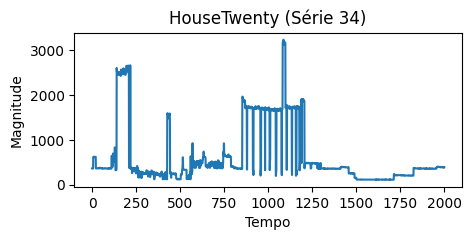

In [4]:
# Podemos plotar uma série temporal para visualização usando o matplotlib
import matplotlib.pyplot as plt

# Neste exemplo, plotamos uma instância qualquer (índice 34) da série do conjunto de treino que carregamos anteriormente do dataset "HouseTwenty"
idx = 34
serie = X_train[idx, 0, :] # Seleciona a série temporal da instância 34, feature 0 (única feature, pois é univariada)

plt.figure(figsize=(5,2))
plt.plot(serie) # Aqui selecionamos a série temporal da instância 34, feature 0 (única feature, pois é univariada) e todos os pontos (:)
plt.title(f"{dataset_name} (Série {idx})")
plt.xlabel("Tempo")
plt.ylabel("Magnitude")
plt.show()

In [5]:
# Para testar a redução de dimensionalidade das series destes datasets, é preciso selecionar series que possuam alta dimensionalidade (>=1000 pontos)
# Para isso, definimos uma lista para armazenar os nomes dos datasets que atendem a este critério

# A fim de verificar a dimensionalidade de cada dataset, iteramos sobre a lista de nomes de datasets originais (pode demorar alguns minutos).
high_dim_datasets = []
for d in datasets:
  X, y = load_classification(d, split='train')
  
  # Podem existir datasets que são implementados com diferentes formatos, sem ser Arrays do Numpy ou DataFrames, então usamos um bloco try-except para evitar erros ao tentar acessar o '.shape'
  try:
    if X.shape[2] >= 1000:
      print(f"{d}: {X.shape[2]}")
      high_dim_datasets.append(d)
  except AttributeError:
    pass

print(f"\n\nLista com o nome dos {len(high_dim_datasets)} datasets de benchmarking com séries univariadas e alta dimensionalidade (>=1000 pontos): \n{high_dim_datasets}")

ACSF1: 1460
CinCECGTorso: 1639
EOGHorizontalSignal: 1250
EOGVerticalSignal: 1250
EthanolLevel: 1751
HandOutlines: 2709
Haptics: 1092
HouseTwenty: 2000
InlineSkate: 1882
Mallat: 1024
MixedShapesRegularTrain: 1024
MixedShapesSmallTrain: 1024
Phoneme: 1024
PigAirwayPressure: 2000
PigArtPressure: 2000
PigCVP: 2000
Rock: 2844
SemgHandGenderCh2: 1500
SemgHandMovementCh2: 1500
SemgHandSubjectCh2: 1500
StarLightCurves: 1024


Lista com o nome dos 21 datasets de benchmarking com séries univariadas e alta dimensionalidade (>=1000 pontos): 
['ACSF1', 'CinCECGTorso', 'EOGHorizontalSignal', 'EOGVerticalSignal', 'EthanolLevel', 'HandOutlines', 'Haptics', 'HouseTwenty', 'InlineSkate', 'Mallat', 'MixedShapesRegularTrain', 'MixedShapesSmallTrain', 'Phoneme', 'PigAirwayPressure', 'PigArtPressure', 'PigCVP', 'Rock', 'SemgHandGenderCh2', 'SemgHandMovementCh2', 'SemgHandSubjectCh2', 'StarLightCurves']


In [6]:
# Para treinar e testar classificadores, podemos utilizar a implementação de diferentes modelos disponíveis na biblioteca aeon
from aeon.classification.convolution_based import RocketClassifier
from aeon.classification.feature_based import Catch22Classifier
# Tambem podemos medir a acurácia (taxa de acerto) dos classificadores utilizando a biblioteca sklearn
from sklearn.metrics import accuracy_score

# Neste exemplo iremos treinar um classificar Rocket e medir sua acurácia no dataset "HouseTwenty" que carregamos anteriormente
# Tambem mediremos o tempo gasto para treinar o classificador utilizando o pacote 'time' importado no início deste notebook
start = time.time()
clf = RocketClassifier(n_kernels=10000, random_state=42)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
end = time.time()

# Calcula o tempo gasto (em segundos) para treinar e testar o classificador (arredondado para 2 casas decimais)
elapsed = np.round(end - start, 2)

# Mede a acurácia das predições utilizando a função accuracy_score da biblioteca sklearn
acc = np.round(accuracy_score(y_test, predictions), 4)

print(f"-> Classificador Rocket\n\tDataset: HouseTwenty\n\tAcurácia: {acc}\n\tTempo gasto: {elapsed} segundos")


-> Classificador Rocket
	Dataset: HouseTwenty
	Acurácia: 0.9664
	Tempo gasto: 23.33 segundos


Na sequência iremos implementar a adaptaçao do algoritimo do **PAA** adaptado para receber o método a ser usado na agregação dos dados. Para facilitar futuras iterações e adaptações começaremos definindo os métodos de agregação que iremos trabalhar.

In [6]:
# Definimos uma lista de funções de agregação que serão aboradadas para a redução de dimensionalidade das séries temporais
aggregations = {
    'average': lambda x: np.mean(x),
    'max': lambda x: np.max(x),
    'min': lambda x: np.min(x),
    'sum': lambda x: np.sum(x),
    'variance': lambda x: np.var(x),
    'std': lambda x: np.std(x),
    'iqr': lambda x: np.subtract(*np.percentile(x, [75, 25])),
    'first': lambda x: x[0],
    'central': lambda x: x[len(x)//2],
    'last': lambda x: x[-1],
    'max-min': lambda x: np.max(x) - np.min(x),
    'avg-max': lambda x: np.abs((np.mean(x) - np.max(x))),
    'avg-min': lambda x: np.abs((np.mean(x) - np.min(x))),
    'random': lambda x: np.random.choice(x)
}

In [7]:
# Aqui implemetamos a adaptação do algorítmo PAA para receber o método de agregação como argumento.
# Além do argumento 'agg' que define a função de agregação, o PAA recebe como argumentos a série temporal 's' que será reduzida e o novo tamanho 'w' desejado.
def PAA(s, w, agg='average'):
    if agg not in aggregations:
        raise ValueError(f"Função de agregação '{agg}' é inválida ou não suportada.")

    n = len(s)
    s = np.array(s)

    # Aqui criamos n valores uniformemente espaçados entre 0 e w (exclusivo).
    # Por exemplo: n=6 e w=2 será [0,0,0,1,1,1]
    idx = np.floor(np.linspace(0, w, n, endpoint=False)).astype(int)

    # Aqui iteramos sobre o tamanho desejado 'w' e aplicamos uma máscara para selecionar os pontos da série que pertencem a cada segmento.
    # Por exemplo: n=6 e w=2, o idx resultante será: 
    #              [True, True, True, False, False, False] para w = 0
    #              Assim podemos selecionar os pontos da série que pertencem a cada segmento.
    res = [aggregations[agg](s[idx == i]) for i in range(w)]

    return np.array(res)

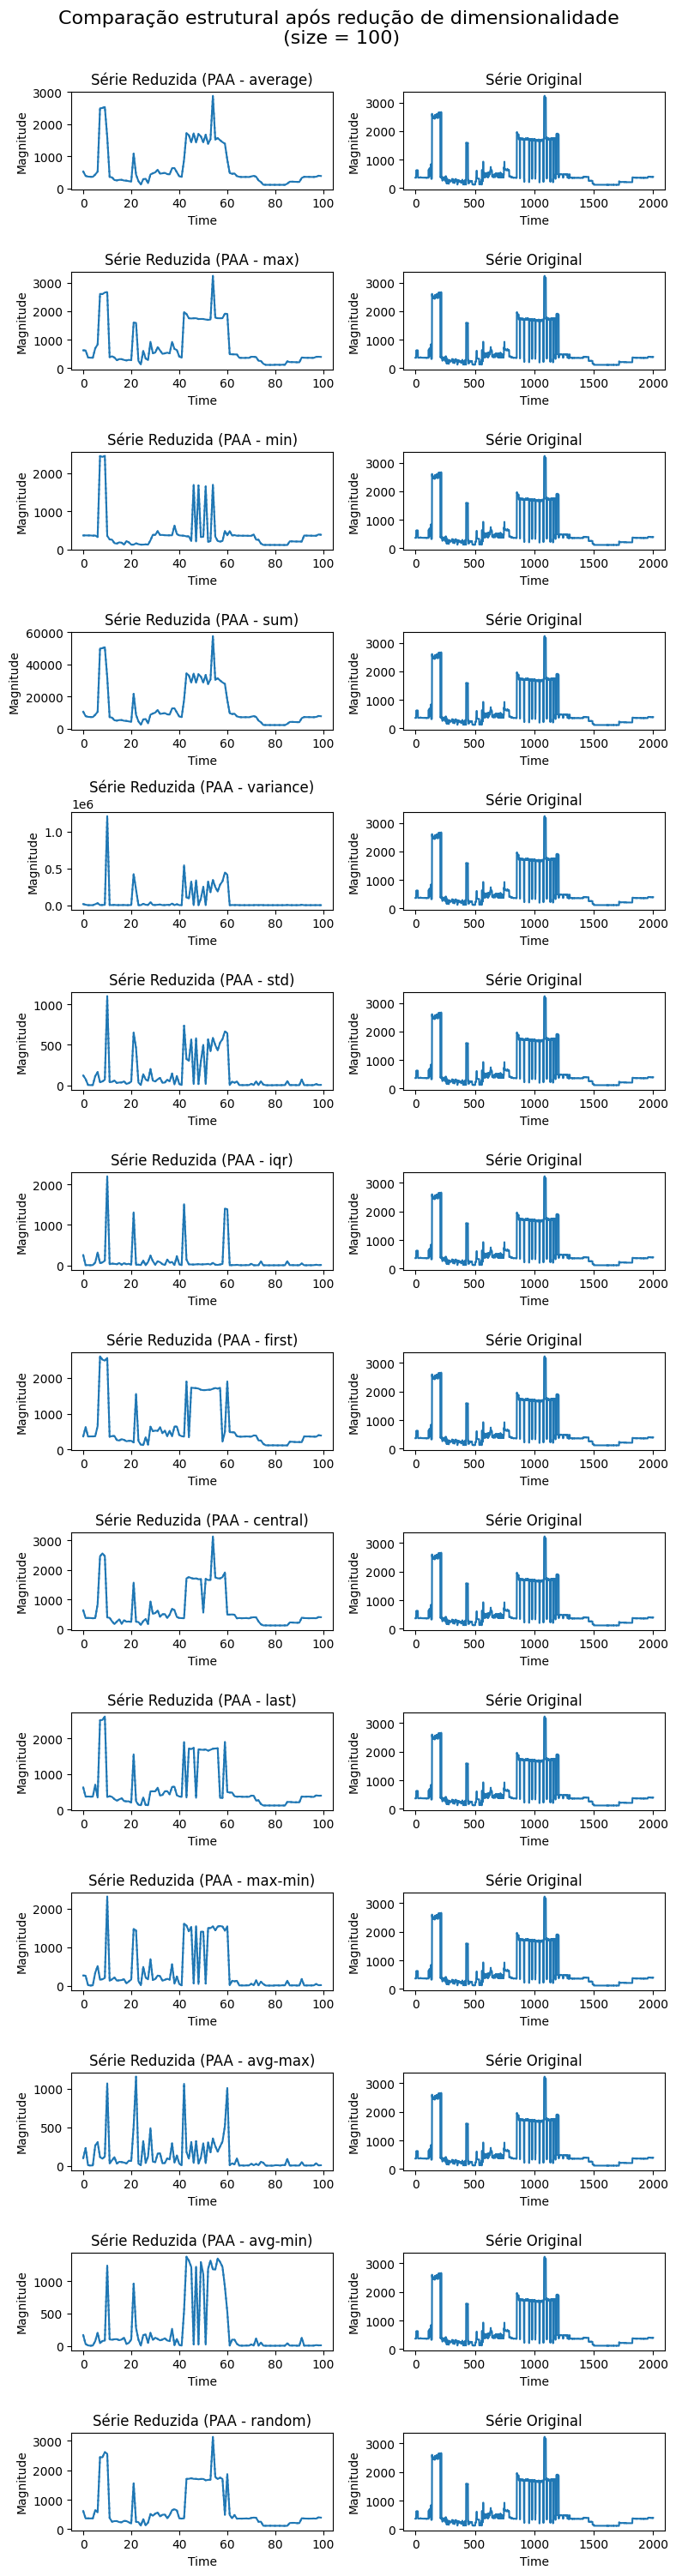

In [8]:
# Podemos testar o PAA com todos os métodos de agregação na instância 'serie' (idx = 34) do dataset "HouseTwenty" carregada anteriormente
# Neste exemplo vamos aplicar uma redução para 100 pontos
size = 100

# Começamos criando a estrutura de plots com 2 colunas (original e reduzida) e uma linha para cada método de agregação
n_rows = len(aggregations.keys())
n_cols = 2
serie_fig_size = (8, 30)

fig, axes = plt.subplots(n_rows, n_cols, figsize=serie_fig_size)
fig.suptitle('Comparação estrutural após redução de dimensionalidade\n (size = 100)', fontsize=16, y=1)

# Iteramos sobre todos os métodos de agregação que definimos e plota os resultados da redução
for i, method in enumerate(aggregations.keys()):
    reduced = PAA(serie, size, agg=method)

    # Plot da série reduzida
    axes[i, 0].plot(reduced)
    axes[i, 0].set_title(f'Série Reduzida (PAA - {method})')
    axes[i, 0].plot(reduced, linestyle=':', color='tab:blue')
    axes[i, 0].set_xlabel('Time')
    axes[i, 0].set_ylabel('Magnitude')

    # Plot da intancia original para comparação.
    axes[i, 1].plot(serie)
    axes[i, 1].set_title('Série Original')
    axes[i, 1].set_xlabel('Time')
    axes[i, 1].set_ylabel('Magnitude')

plt.tight_layout()
plt.show()

Na sequência iremos iremos testar o impacto desta redução nas tarefas de classificação. Para isso iremos aplicar a redução `PAA()` que implementamos em todos os dataset de alta dimensionalidade que separamos anteriormente `high_dim_datasets`. Essa redução sera feita tanto nos dados de teste como de treinamento (X_train e X_test).

Porém, precisamos antes definir quais classificadores serão usados

In [9]:
# Definimos os classificadores a serem usados nos testes, similar ao que fizemos anteriormente para as 'aggregations'
classifiers = {
    'Rocket': RocketClassifier(n_kernels=10000, random_state=42),
    'Catch22': Catch22Classifier()
}

# Definimos as taxas percentuais de redução a serem testadas. (0 ~ 1)
# IMPORTANTE: Testar taxas de redução baixas (proximas de 0) podem implicar em mais demora na hora de rodar os testes de treinamento
# Ex: 
#   - tamanho original de 1000, 
#   - percentual de reducao de 0.1
#   - resulta em 1000 - 100 = 900
reduction_rates = [
    0.9,
    0.8,
    0.7,
    0.6,
    0.5,
    0.4,
    0.3,
]

NameError: name 'RocketClassifier' is not defined

In [10]:
# Definimos uma função para executar os treinamentos de classificadores utilizando o PAA com diferentes métodos de agregação
# A função recebe como argumentos a lista de datasets, a lista de métodos de agregação e a lista de classificadores
def run_paa_tests(datasets, aggregations, classifiers, reduction_rates):
  # Cria a lista de resultados
  results = []
  results_path = './tests/classification/paa/results.csv'

  # Verifica se existem resultados base (sem redução) dos classificadores para evitar retrabalho desnecessário
  baseline_classifiers_results_path = './.cache/classification/results.csv'
  baseline_results_df = pd.DataFrame(columns=['dataset', 'classifier', 'accuracy', 'elapsed_time'])
  if os.path.exists(baseline_classifiers_results_path):
        baseline_results_df = pd.read_csv(baseline_classifiers_results_path)

  # Iteramos sobre cada Dataset
  for d in datasets:
    print(f'[Dataset]: {d}')
    X_train, y_train = load_classification(d, split="train")
    X_test, y_test = load_classification(d, split="test")
    original_size = X_train.shape[2]

    # Executa baseline (sem redução) apenas para referência
    for clf_name, clf in classifiers.items():
        print(f'\t[Classificador]: {clf_name}')
        print(f'\t\t[Sem redução]', end=' ')

        # Verifica se o classificador ja possui o cache dos dados base de treinamento
        baseline_row = baseline_results_df[(baseline_results_df['dataset'] == d) & (baseline_results_df['classifier'] == clf_name)]

        # Se já existe, reutiliza o resultado ao invés de treinar novamente
        if not baseline_row.empty:
            baseline_acc = float(baseline_row['accuracy'].values[0])
            baseline_time = float(baseline_row['elapsed_time'].values[0])
            print(f'-> Resultados do treinamento reutilizado.')
        
        # Se não existe, treina o classificador normalmente
        else:
            start = time.time()
            clf.fit(X_train, y_train)
            predictions = clf.predict(X_test)
            end = time.time()

            baseline_acc = np.round(accuracy_score(y_test, predictions), 4)
            baseline_time = np.round(end - start, 2)
            print(f'-> Treinamento finalizado. ({baseline_time}s)')

            # Adiciona os resultados base (sem redução) do classificador no DataFrame de cache
            row = pd.DataFrame([{
                'dataset': d,
                'classifier': clf_name,
                'accuracy': baseline_acc,
                'elapsed_time': baseline_time
            }])
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=FutureWarning)
                baseline_results_df = pd.concat([baseline_results_df, row], ignore_index=True)
            # Salva o DataFrame de cache em um arquivo CSV para uso posterior
            os.makedirs(os.path.dirname(baseline_classifiers_results_path), exist_ok=True)
            baseline_results_df.to_csv(baseline_classifiers_results_path, index=False)

        # Itera sobre cada taxa de redução definida
        for rate in reduction_rates:
            if rate <= 0 or rate >= 1:
                continue
            
            print(f'\t\t[Taxa de reduçao]: {rate*100}%')
            # Define o tamanho 'w' a ser utilizado no PAA como o tamanho original menos a porcentagem de redução
            w = original_size - int((original_size * rate))

            # Itera sobre cada método de agregação definido
            for agg in aggregations.keys():
                print(f'\t\t\t[PAA | {agg}]', end=' ')
                X_train_reduced = np.array([PAA(s[0], w=w, agg=agg) for s in X_train])
                X_test_reduced = np.array([PAA(x[0], w=w, agg=agg) for x in X_test])

                start = time.time()
                clf.fit(X_train_reduced, y_train)
                predictions = clf.predict(X_test_reduced)
                end = time.time()

                acc = np.round(accuracy_score(y_test, predictions), 4)
                elapsed = np.round(end - start, 2)
                reduction_percent = rate
                acc_diff_percent = np.round((acc - baseline_acc) * 100, 2)
                time_diff = np.round(elapsed - baseline_time, 2)

                print(f'-> Treinamento finalizado. ({elapsed}s)')

                results.append({
                    'dataset': d,
                    'classifier': clf_name,
                    'aggregation': agg,
                    'original_size': original_size,
                    'reduced_size': X_train_reduced.shape[1],
                    'reduction_percent': reduction_percent,
                    'accuracy': acc,
                    'original_accuracy': baseline_acc,
                    'acc_diff_percent': acc_diff_percent,
                    'elapsed_time': elapsed,
                    'baseline_time': baseline_time,
                    'time_diff': time_diff
                })

  # Converte os resultados para um DataFrame do Pandas e salva o CSV
  df = pd.DataFrame(results)
  os.makedirs(os.path.dirname(results_path), exist_ok=True)
  df.to_csv(results_path, index=False)

  return df

In [12]:
# Executa os treinamentos apenas com o dataset "HouseTwenty" para demonstração
# Para executar os testes em todos os datasets com alta dimensionalidade, substitua a lista de datasets por high_dim_datasets
# IMPORTANTE: A execução dos testes em todos os datasets com alta dimensionalidade pode levar várias horas.
results = run_paa_tests(datasets=high_dim_datasets, aggregations=aggregations, classifiers=classifiers, reduction_rates=reduction_rates)

[Dataset]: ACSF1
	[Classificador]: Rocket
		[Sem redução] -> Resultados do treinamento reutilizado.
		[Taxa de reduçao]: 90.0%
			[PAA | average] -> Treinamento finalizado. (2.1s)
			[PAA | max] -> Treinamento finalizado. (2.14s)
			[PAA | min] -> Treinamento finalizado. (2.19s)
			[PAA | sum] -> Treinamento finalizado. (2.14s)
			[PAA | variance] -> Treinamento finalizado. (2.12s)
			[PAA | std] -> Treinamento finalizado. (2.09s)
			[PAA | iqr] -> Treinamento finalizado. (2.09s)
			[PAA | first] -> Treinamento finalizado. (2.17s)
			[PAA | central] -> Treinamento finalizado. (2.11s)
			[PAA | last] -> Treinamento finalizado. (2.12s)
			[PAA | max-min] -> Treinamento finalizado. (2.13s)
			[PAA | avg-max] -> Treinamento finalizado. (2.16s)
			[PAA | avg-min] -> Treinamento finalizado. (2.28s)
			[PAA | random] -> Treinamento finalizado. (2.15s)
		[Taxa de reduçao]: 80.0%
			[PAA | average] -> Treinamento finalizado. (4.18s)
			[PAA | max] -> Treinamento finalizado. (4.1s)
			[PAA | min

In [11]:
results = pd.read_csv('./tests/classification/paa/results.csv')

In [202]:
results.head()

,dataset,classifier,aggregation,original_size,reduced_size,reduction_percent,accuracy,original_accuracy,acc_diff_percent,elapsed_time,baseline_time,time_diff
0,ACSF1,Rocket,average,1460,146,0.9,0.59,0.89,-30.0,2.10,21.0,-18.90
1,ACSF1,Rocket,max,1460,146,0.9,0.31,0.89,-58.0,2.14,21.0,-18.86
2,ACSF1,Rocket,min,1460,146,0.9,0.49,0.89,-40.0,2.19,21.0,-18.81
3,ACSF1,Rocket,sum,1460,146,0.9,0.59,0.89,-30.0,2.14,21.0,-18.86
4,ACSF1,Rocket,variance,1460,146,0.9,0.54,0.89,-35.0,2.12,21.0,-18.88


---

# 1. Análise dá diferença de acurácia

### 1.2 Separado por método de agregação

   aggregation  acc_diff_percent
0      average         -1.299490
1          max         -1.854320
2         last         -1.942517
3      central         -2.457177
4          min         -2.654762
5          sum         -2.664898
6        first         -2.873129
7       random         -4.461905
8          std         -9.886463
9      max-min        -10.299490
10     avg-max        -10.507959
11     avg-min        -10.519694
12         iqr        -11.153435
13    variance        -12.684354


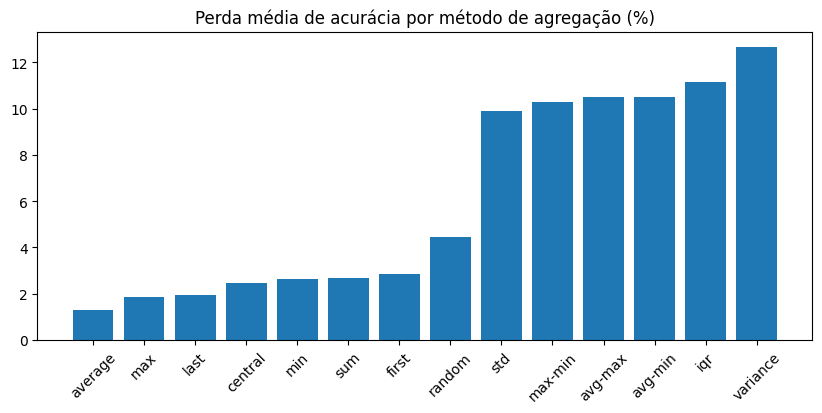

In [203]:
# Agrupa os resultados por método de agregação usando a média da diferença percentual de acurácia
grouped_mean_agg_results = results.groupby('aggregation')['acc_diff_percent'].mean().sort_values(ascending=False).reset_index()
print(grouped_mean_agg_results)

# Plot
plt.figure(figsize=(10,4))
plt.bar(grouped_mean_agg_results['aggregation'], grouped_mean_agg_results['acc_diff_percent'].abs())
plt.title('Perda média de acurácia por método de agregação (%)')
plt.xticks(rotation=45)
plt.show()

#### 1.2.1 Separado por taxa de redução

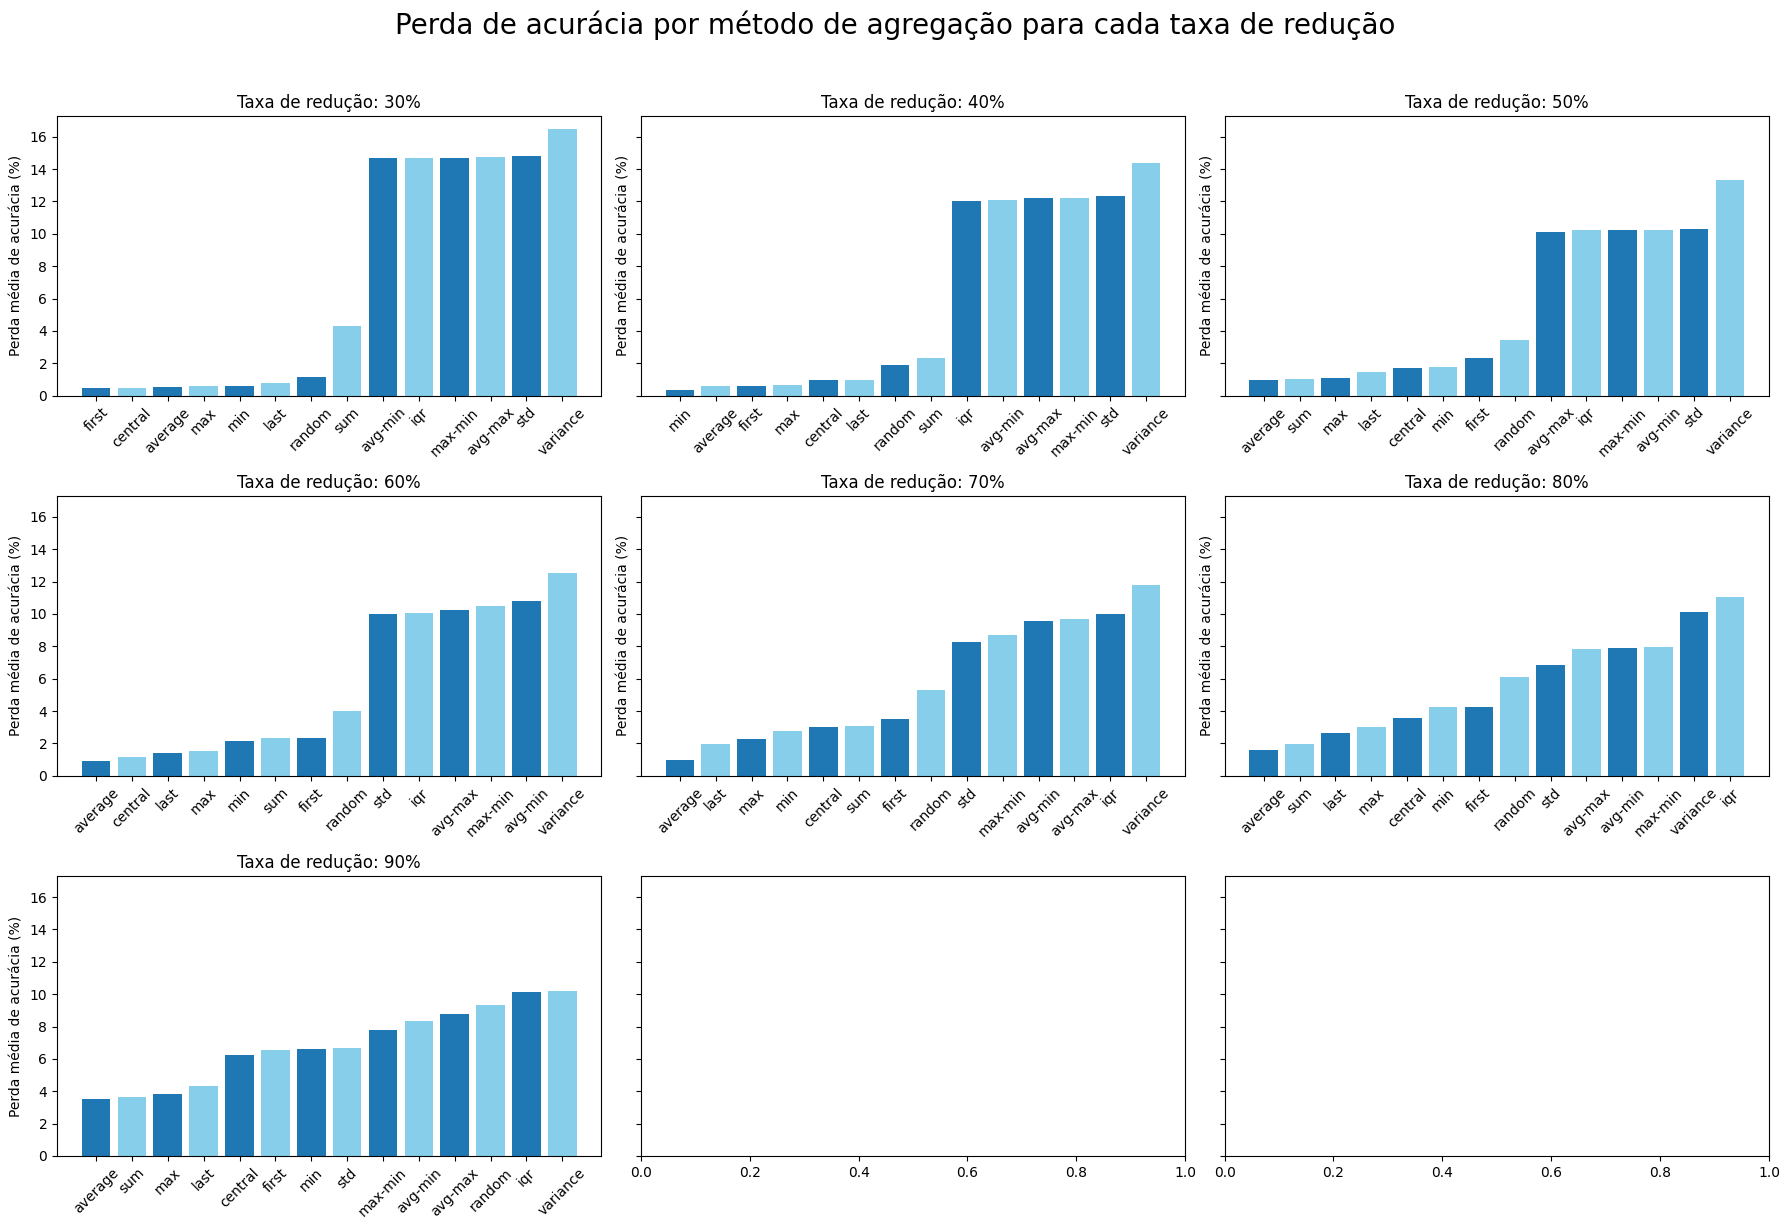

In [204]:
# Analisa a perda média de acurácia para cada percentual de redução utilizado
reduction_rates = results['reduction_percent'].unique()
reduction_rates.sort()

# Define a estrutura de plots com múltiplas linhas e colunas
n_rates = len(reduction_rates)
n_cols = min(3, n_rates)
n_rows = int(np.ceil(n_rates / n_cols))

# Cria a figura e os eixos dos plots a serem inseridos
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), sharey=True)
axes = axes.flatten()

# Itera sobre cada taxa de redução e adiciona o plot a figura
for idx, rate in enumerate(reduction_rates):
    # Cria o filtro para selecionar os resultados com a taxa de redução atual
    filters = results['reduction_percent'] == rate
    filtered_results = results[filters]

    # Agrupa os resultados por método de agregação
    grouped_results = filtered_results.groupby('aggregation')['acc_diff_percent'].mean().reset_index()
    grouped_results = grouped_results.sort_values(by='acc_diff_percent', ascending=False)

    # Plot no subplot correspondente
    ax = axes[idx]
    ax.bar(grouped_results['aggregation'], grouped_results['acc_diff_percent'].abs(), color=['tab:blue', 'skyblue'])
    ax.set_title(f'Taxa de redução: {rate*100:.0f}%')
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel('Perda média de acurácia (%)')

plt.suptitle('Perda de acurácia por método de agregação para cada taxa de redução', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()


#### 1.2.1 Separado por classificador

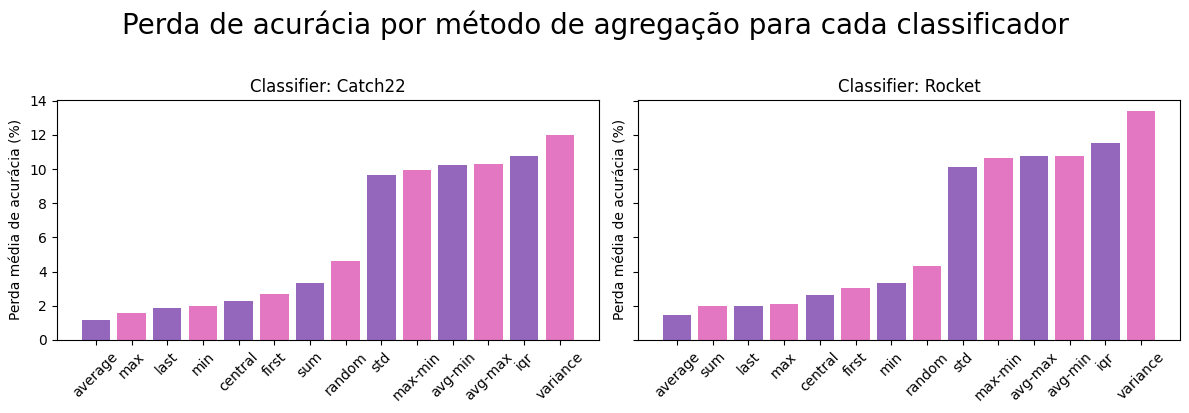

In [228]:
# Analisa a perda média de acurácia para cada classificador utilizado
clfs = results['classifier'].unique()
clfs.sort()

# Define a estrutura de plots com múltiplas linhas e colunas
n_clfs = len(clfs)
n_cols = min(3, n_clfs)
n_rows = int(np.ceil(n_clfs / n_cols))

# Cria a figura e os eixos dos plots a serem inseridos
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), sharey=True)
axes = axes.flatten()

# Itera sobre cada taxa de redução e adiciona o plot a figura
for idx, clf in enumerate(clfs):
    # Cria o filtro para selecionar os resultados com a taxa de redução atual
    filters = results['classifier'] == clf
    filtered_results = results[filters]

    # Agrupa os resultados por método de agregação
    grouped_results = filtered_results.groupby('aggregation')['acc_diff_percent'].mean().reset_index()
    grouped_results = grouped_results.sort_values(by='acc_diff_percent', ascending=False)

    # Plot no subplot correspondente
    ax = axes[idx]
    ax.bar(grouped_results['aggregation'], grouped_results['acc_diff_percent'].abs(), color=['tab:purple', 'tab:pink'])
    ax.set_title(f'Classifier: {clf}')
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel('Perda média de acurácia (%)')

plt.suptitle('Perda de acurácia por método de agregação para cada classificador', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()


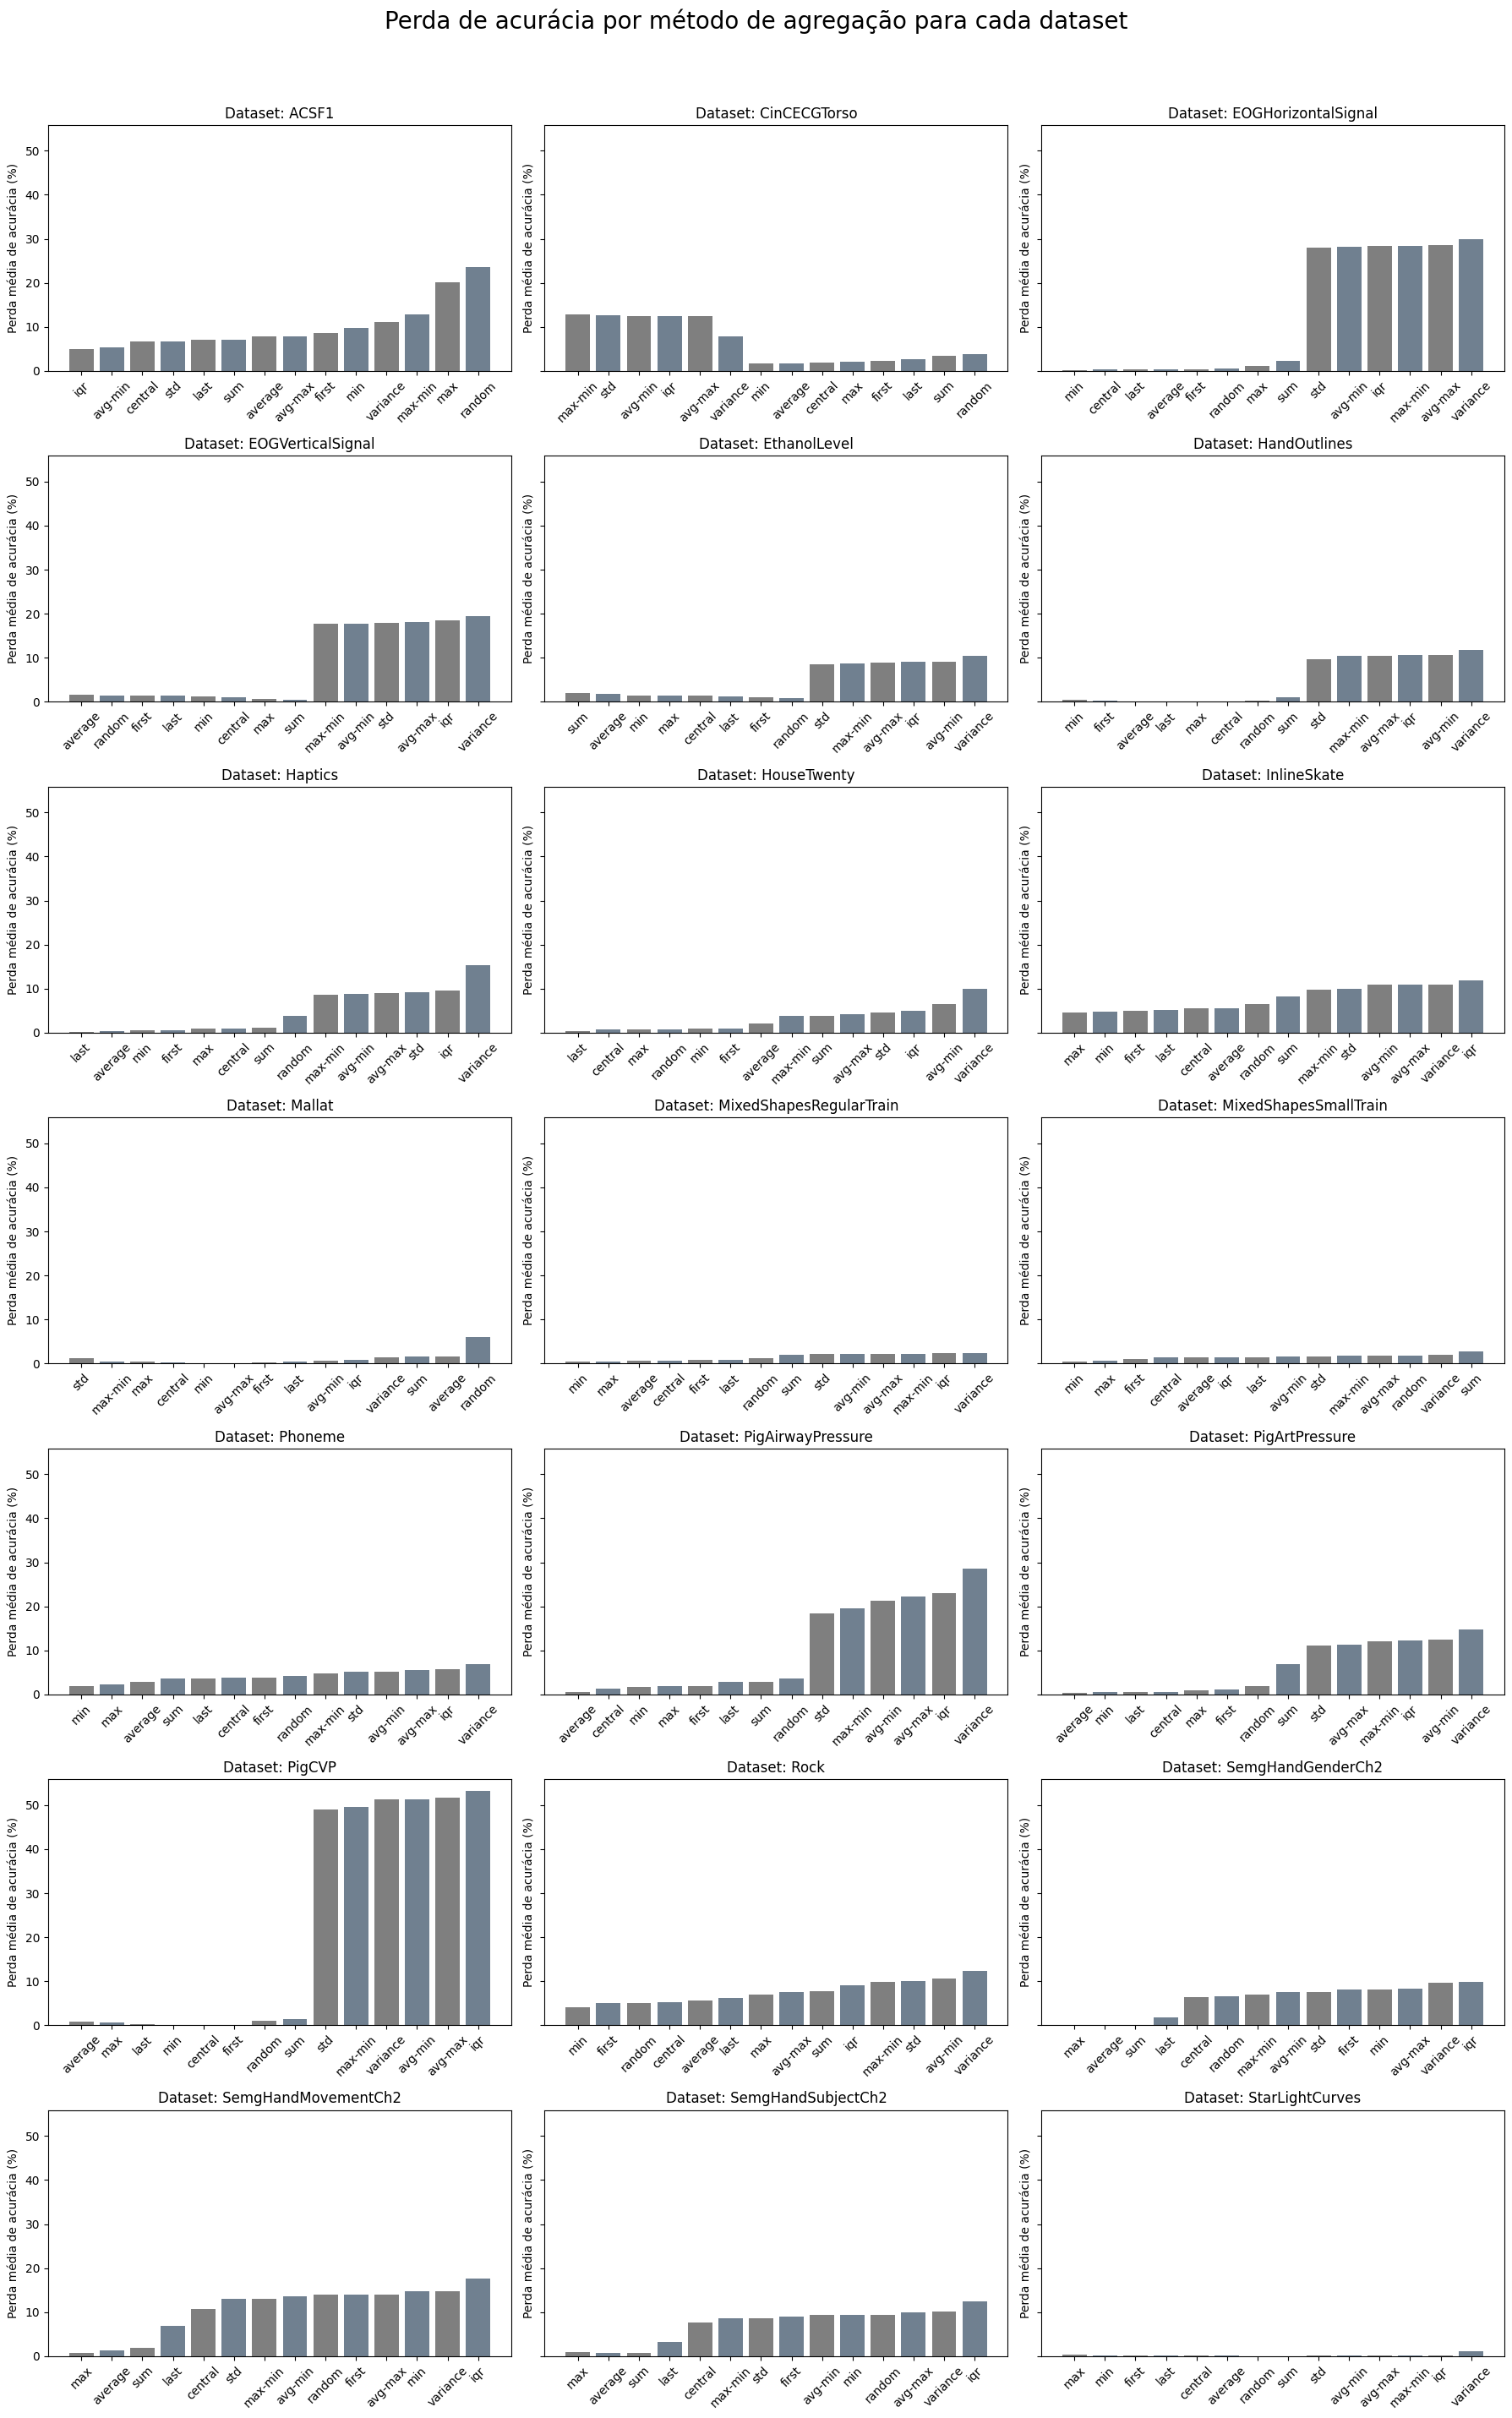

In [227]:
# Analisa a perda média de acurácia para cada dataset utilizado
series_datasets = results['dataset'].unique()
series_datasets.sort()

# Define a estrutura de plots com múltiplas linhas e colunas
n_datasets = len(series_datasets)
n_cols = min(3, n_datasets)
n_rows = int(np.ceil(n_datasets / n_cols))

# Cria a figura e os eixos dos plots a serem inseridos
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), sharey=True)
axes = axes.flatten()

# Itera sobre cada taxa de redução e adiciona o plot a figura
for idx, dataset in enumerate(series_datasets):
    # Cria o filtro para selecionar os resultados com a taxa de redução atual
    filters = results['dataset'] == dataset
    filtered_results = results[filters]

    # Agrupa os resultados por método de agregação
    grouped_results = filtered_results.groupby('aggregation')['acc_diff_percent'].mean().reset_index()
    grouped_results = grouped_results.sort_values(by='acc_diff_percent', ascending=False)

    # Plot no subplot correspondente
    ax = axes[idx]
    ax.bar(grouped_results['aggregation'], grouped_results['acc_diff_percent'].abs(), color=['tab:gray', 'slategray'])
    ax.set_title(f'Dataset: {dataset}')
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel('Perda média de acurácia (%)')

plt.suptitle('Perda de acurácia por método de agregação para cada dataset', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()


Pelas análises de perda média de acurácia separada por diferentes variáveis, como taxa de redução, classificador e dataset, é possível observar que o dataset é o que mais impacta nas variações de perda de acurácia. Tendo alguns apresentando uma simetria em relação os melhores métodos de agregação, como o **"CinCECGETorso"** e o **"EthanolLevel"**

# 2. Análise dos **ganhos** de acurácia

In [180]:
# Filtra os results que tiverem ganhos na acurácia
acc_gain_results = results[results['acc_diff_percent'] > 0]
# Ordena os resultados pela maior acurácia positiva
acc_gain_results = acc_gain_results.sort_values(by='acc_diff_percent', ascending=False)

print(f"Total de treinamentos com ganho de acurácia: {len(acc_gain_results)} de {len(results)}")
acc_gain_results.head()

Total de treinamentos com ganho de acurácia: 809 de 4116


,dataset,classifier,aggregation,original_size,reduced_size,reduction_percent,accuracy,original_accuracy,acc_diff_percent,elapsed_time,baseline_time,time_diff
207,CinCECGTorso,Rocket,avg-max,1639,164,0.9,0.9899,0.8304,15.95,16.15,163.65,-147.50
229,CinCECGTorso,Rocket,std,1639,492,0.7,0.9884,0.8304,15.80,48.36,163.65,-115.29
230,CinCECGTorso,Rocket,iqr,1639,492,0.7,0.9877,0.8304,15.73,48.35,163.65,-115.30
235,CinCECGTorso,Rocket,avg-max,1639,492,0.7,0.9870,0.8304,15.66,48.35,163.65,-115.30
202,CinCECGTorso,Rocket,iqr,1639,164,0.9,0.9862,0.8304,15.58,16.16,163.65,-147.49


### 2.1 Separado por método de agregação

aggregation
average     102
max          92
min          81
first        79
central      74
last         74
sum          67
random       49
avg-max      35
max-min      35
std          35
avg-min      32
iqr          31
variance     23
dtype: int64


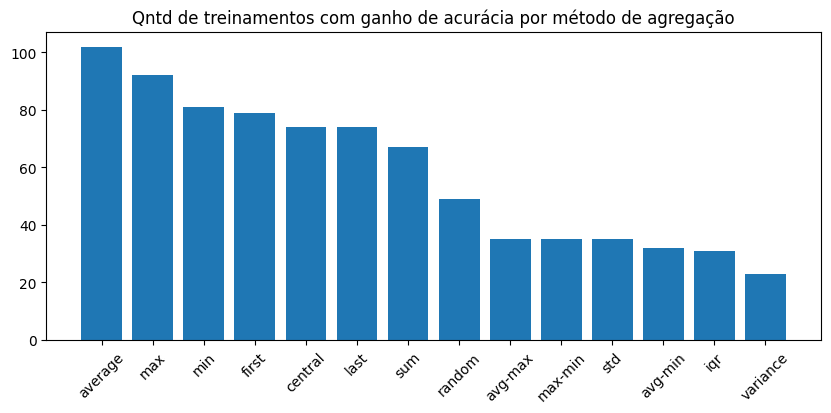

In [101]:
# Agrupada os resultados que tiverem aumento de acurácia por método de agregação
grouped_agg_acc_gain_counts = acc_gain_results.groupby('aggregation').size()
# Ordena os resultados pela maior contagem
grouped_agg_acc_gain_counts = grouped_agg_acc_gain_counts.sort_values(ascending=False)

print(grouped_agg_acc_gain_counts)

# Plot
plt.figure(figsize=(10,4))
plt.title('Qntd de treinamentos com ganho de acurácia por método de agregação')
plt.bar(grouped_agg_acc_gain_counts.index, grouped_agg_acc_gain_counts.values)
plt.xticks(rotation=45)
plt.show()

### 2.2 Separado por classificador

classifier
Catch22    519
Rocket     290
dtype: int64


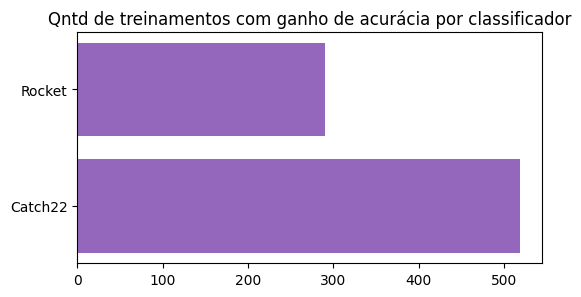

In [171]:
# Agrupada os resultados que tiverem aumento de acurácia por classificador
grouped_clf_acc_gain_counts = acc_gain_results.groupby('classifier').size()
# Ordena os resultados pela maior contagem
grouped_clf_acc_gain_counts = grouped_clf_acc_gain_counts.sort_values(ascending=False)

print(grouped_clf_acc_gain_counts)

# Plot
plt.figure(figsize=(6,3))
plt.title('Qntd de treinamentos com ganho de acurácia por classificador')
plt.barh(grouped_clf_acc_gain_counts.index, grouped_clf_acc_gain_counts.values, color='tab:purple')
plt.show()

### 2.3 Separado por taxa de redução

reduction_percent
0.5    142
0.3    125
0.6    122
0.4    120
0.7    113
0.8    112
0.9     75
dtype: int64


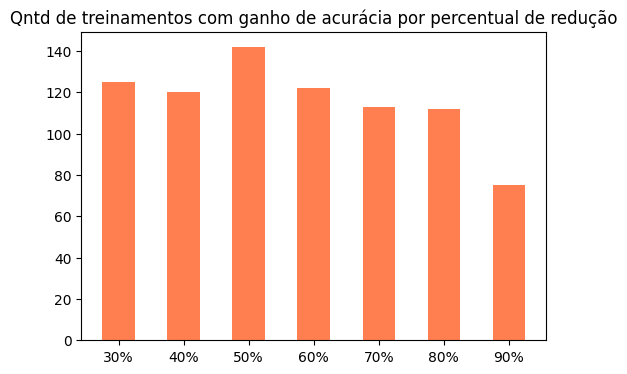

In [200]:
# Agrupada os resultados que tiverem aumento de acurácia por método de agregação
grouped_reduction_rate_acc_gain_counts = acc_gain_results.groupby('reduction_percent').size()
# Ordena os resultados pelo valor do percentual de redução
grouped_reduction_rate_acc_gain_counts = grouped_reduction_rate_acc_gain_counts.sort_values(ascending=False)

print(grouped_reduction_rate_acc_gain_counts)

# Plot
plt.figure(figsize=(6,4))
plt.title('Qntd de treinamentos com ganho de acurácia por percentual de redução')
plt.bar(grouped_reduction_rate_acc_gain_counts.index, grouped_reduction_rate_acc_gain_counts.values, width=0.05, color='coral')
# Exibe os valores percentuais no eixo x formatados como porcentagem
plt.xticks(
    ticks=grouped_reduction_rate_acc_gain_counts.index,
    labels=[f"{int(rate*100)}%" for rate in grouped_reduction_rate_acc_gain_counts.index]
)
plt.show()

### 2.4 Separado por dataset

dataset
StarLightCurves            112
CinCECGTorso               100
EOGVerticalSignal           87
Mallat                      65
EthanolLevel                58
PigCVP                      53
HandOutlines                43
SemgHandSubjectCh2          39
SemgHandGenderCh2           36
PigArtPressure              34
Haptics                     33
HouseTwenty                 28
EOGHorizontalSignal         25
PigAirwayPressure           24
ACSF1                       22
MixedShapesSmallTrain       17
SemgHandMovementCh2         15
Rock                        11
MixedShapesRegularTrain      4
InlineSkate                  3
dtype: int64


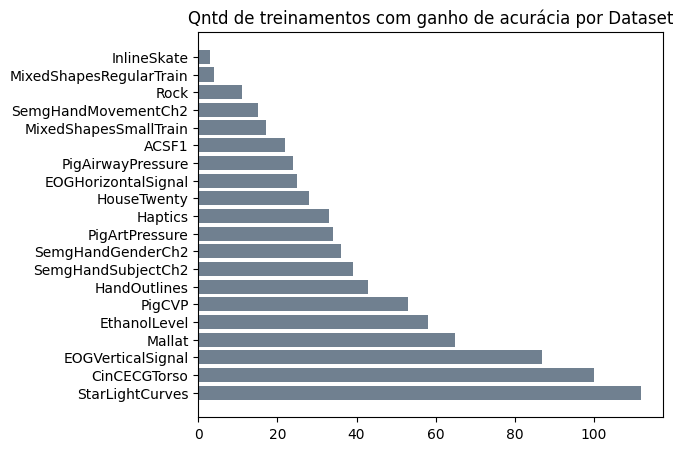

In [179]:
# Agrupada os resultados que tiverem aumento de acurácia por dataset
grouped_dataset_acc_gain_counts = acc_gain_results.groupby('dataset').size()
# Ordena os resultados pela maior contagem
grouped_dataset_acc_gain_counts = grouped_dataset_acc_gain_counts.sort_values(ascending=False)

print(grouped_dataset_acc_gain_counts)

# Plot
plt.figure(figsize=(6,5))
plt.title('Qntd de treinamentos com ganho de acurácia por Dataset')
plt.barh(grouped_dataset_acc_gain_counts.index, grouped_dataset_acc_gain_counts.values, color='slategray')
plt.show()

# 3. Análises não categorizadas

In [103]:
# Ordena os resultados por acurácia decrescente
filtered_results = results.sort_values(by='acc_diff_percent', ascending=False)
# Exibe os 20 melhores resultados no ganho de acurácia
filtered_results.head(20)

,dataset,classifier,aggregation,original_size,reduced_size,reduction_percent,accuracy,original_accuracy,acc_diff_percent,elapsed_time,baseline_time,time_diff
207,CinCECGTorso,Rocket,avg-max,1639,164,0.9,0.9899,0.8304,15.95,16.15,163.65,-147.50
229,CinCECGTorso,Rocket,std,1639,492,0.7,0.9884,0.8304,15.80,48.36,163.65,-115.29
230,CinCECGTorso,Rocket,iqr,1639,492,0.7,0.9877,0.8304,15.73,48.35,163.65,-115.30
235,CinCECGTorso,Rocket,avg-max,1639,492,0.7,0.9870,0.8304,15.66,48.35,163.65,-115.30
202,CinCECGTorso,Rocket,iqr,1639,164,0.9,0.9862,0.8304,15.58,16.16,163.65,-147.49
234,CinCECGTorso,Rocket,max-min,1639,492,0.7,0.9855,0.8304,15.51,48.35,163.65,-115.30
206,CinCECGTorso,Rocket,max-min,1639,164,0.9,0.9848,0.8304,15.44,16.18,163.65,-147.47
201,CinCECGTorso,Rocket,std,1639,164,0.9,0.9848,0.8304,15.44,16.17,163.65,-147.48
885,EthanolLevel,Catch22,sum,1751,176,0.9,0.4920,0.3380,15.40,0.83,2.99,-2.16
236,CinCECGTorso,Rocket,avg-min,1639,492,0.7,0.9841,0.8304,15.37,48.36,163.65,-115.29


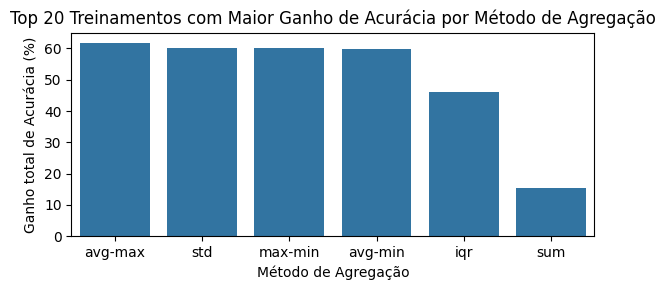

In [126]:
# Seleionamos os 20 melhores resultados no ganho de acurácia
top_20 = filtered_results.head(20)

# Agrupa os resultados por método de agregação e soma o ganho de acurácia
top_20 = top_20.groupby('aggregation')['acc_diff_percent'].sum().reset_index()
top_20 = top_20.sort_values(by='acc_diff_percent', ascending=False)

plt.figure(figsize=(6,3))
sns.barplot(data=top_20, y='acc_diff_percent', x='aggregation', errorbar=None)
plt.xlabel('Método de Agregação')
plt.ylabel('Ganho total de Acurácia (%)')
plt.title('Top 20 Treinamentos com Maior Ganho de Acurácia por Método de Agregação')
plt.tight_layout()
plt.show()

In [85]:
# Remove os dados do dataset "CinCECGTorso"
filtered_results = filtered_results[filtered_results['dataset'] != 'CinCECGTorso']
filtered_results.head(20)

,dataset,classifier,aggregation,original_size,reduced_size,reduction_percent,accuracy,original_accuracy,acc_diff_percent,elapsed_time,baseline_time,time_diff
885,EthanolLevel,Catch22,sum,1751,176,0.9,0.4920,0.3380,15.40,0.83,2.99,-2.16
890,EthanolLevel,Catch22,central,1751,176,0.9,0.4700,0.3380,13.20,0.90,2.99,-2.09
2593,PigAirwayPressure,Rocket,sum,2000,800,0.6,0.5048,0.3942,11.06,17.45,46.53,-29.08
883,EthanolLevel,Catch22,max,1751,176,0.9,0.4480,0.3380,11.00,0.83,2.99,-2.16
884,EthanolLevel,Catch22,min,1751,176,0.9,0.4460,0.3380,10.80,0.84,2.99,-2.15
3296,Rock,Catch22,iqr,2844,1422,0.5,0.8000,0.7000,10.00,0.41,0.52,-0.11
3301,Rock,Catch22,avg-max,2844,1422,0.5,0.8000,0.7000,10.00,0.42,0.52,-0.10
882,EthanolLevel,Catch22,average,1751,176,0.9,0.4280,0.3380,9.00,0.82,2.99,-2.17
3300,Rock,Catch22,max-min,2844,1422,0.5,0.7800,0.7000,8.00,0.42,0.52,-0.10
3302,Rock,Catch22,avg-min,2844,1422,0.5,0.7800,0.7000,8.00,0.41,0.52,-0.11


In [17]:
# # Gera e salva amostras aleatórias de séries para todos os datasets de alta dimensionalidade
# dataset_plot_samples_path = './datasets/samples'
# os.makedirs(dataset_plot_samples_path, exist_ok=True)
# n_samples = 50
# n_plot_cols = 5

# for dataset_name in high_dim_datasets:
#     try:
#         X, y = load_classification(dataset_name, split='train')
#         np.random.seed(42)
#         n_series = X.shape[0]
#         if n_series < n_samples:
#             sample_indices = np.arange(n_series)
#         else:
#             sample_indices = np.random.choice(n_series, n_samples, replace=False)
#         n_rows = len(sample_indices) // n_plot_cols + (len(sample_indices) % n_plot_cols > 0)

#         fig, axes = plt.subplots(n_rows, n_plot_cols, figsize=(n_plot_cols * 3, n_rows * 2), sharex=True, sharey=True)
#         axes = axes.flatten()

#         for i, idx in enumerate(sample_indices):
#             serie_i = X[idx, 0, :]
#             label_i = y[idx]
#             axes[i].plot(serie_i)
#             axes[i].set_title(f"Série {idx} - Label: {label_i}")
#             axes[i].set_xlabel("Tempo")
#             axes[i].set_ylabel("Magnitude")

#         # Remove subplots vazios
#         for j in range(len(sample_indices), n_rows * n_plot_cols):
#             fig.delaxes(axes[j])

#         fig.suptitle(f"{len(sample_indices)} séries aleatórias do dataset {dataset_name}", fontsize=16)
#         plt.tight_layout(rect=[0, 0, 1, 0.97])
#         plt.savefig(f"{dataset_plot_samples_path}/{dataset_name.lower()}.png", dpi=100, bbox_inches='tight')
#         plt.close(fig)
#         print(f"Salvo: {dataset_name}")
#     except Exception as e:
#         print(f"Erro em {dataset_name}: {e}")

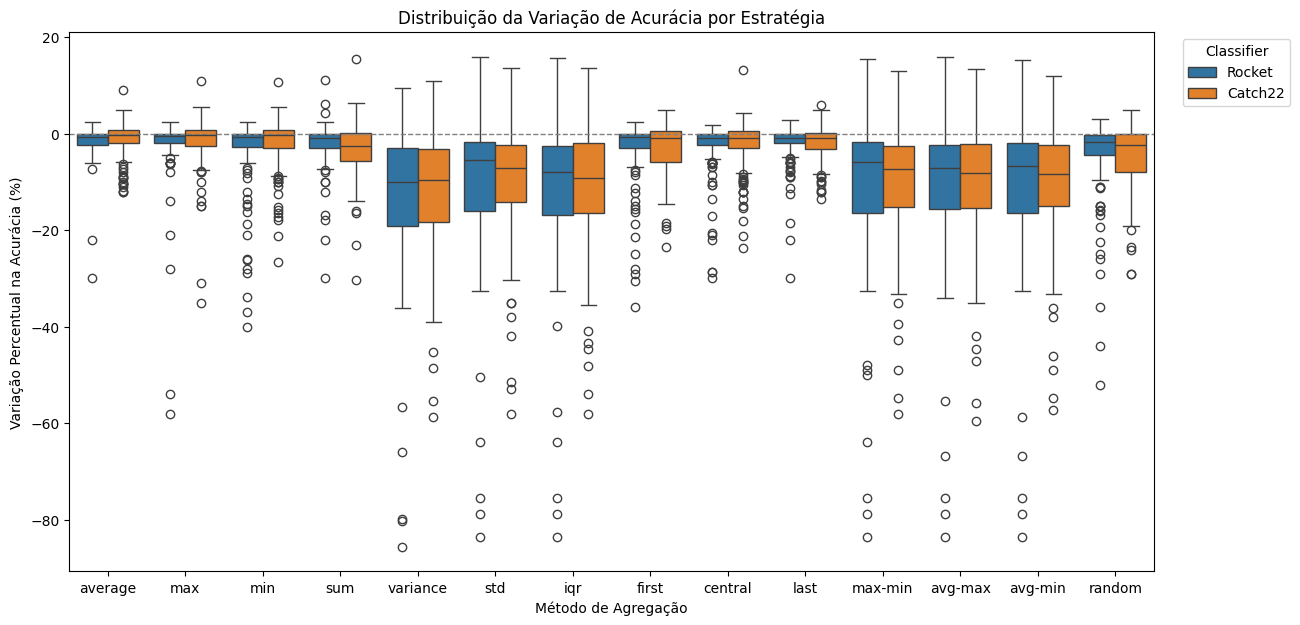

In [212]:
plt.figure(figsize=(14, 7))

# Boxplot para ver a distribuição dos resultados
sns.boxplot(
    data=results,
    x='aggregation',
    y='acc_diff_percent',
    hue='classifier' # Agrupa por classificador dentro de cada método de agregação
)

plt.axhline(0, color='grey', linestyle='--', lw=1)
plt.title('Distribuição da Variação de Acurácia por Estratégia')
plt.xlabel('Método de Agregação')
plt.ylabel('Variação Percentual na Acurácia (%)')
plt.legend(title='Classifier', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()